<a href="https://colab.research.google.com/github/ImJongHwan/practice-ml-nlp/blob/main/11_convolution_neural_network_for_NLP/6_Intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전 훈련된 워드 임베딩을 이용한 의도 분류(Intent Classification using Pre-trained Word Embedding)

https://wikidocs.net/86083

## 데이터 로드와 전처리

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_train_data.csv", filename="intent_train_data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/11.%201D%20CNN%20Text%20Classification/dataset/intent_test_data.csv", filename="intent_test_data.csv")

train_data = pd.read_csv('intent_train_data.csv')
test_data = pd.read_csv('intent_test_data.csv')

In [3]:
train_data

,intent,label
0,add another song to the cita rom ntica playlist,AddToPlaylist
1,add clem burke in my playlist pre party r b jams,AddToPlaylist
2,add live from aragon ballroom to trapeo,AddToPlaylist
3,add unite and win to my night out,AddToPlaylist
4,add track to my digster future hits,AddToPlaylist
...,...,...
11779,can a i get the movie schedule for sympathy fo...,SearchScreeningEvent
11780,find movie schedules for animated movies aroun...,SearchScreeningEvent
11781,what time is bordertown trail showing,SearchScreeningEvent
11782,in the neighbourhood find movies with movie times,SearchScreeningEvent


In [4]:
test_data

,intent,label
0,i 'd like to have this track onto my classical...,AddToPlaylist
1,add the album to my flow espa ol playlist,AddToPlaylist
2,add digging now to my young at heart playlist,AddToPlaylist
3,add this song by too poetic to my piano ballad...,AddToPlaylist
4,add this album to old school death metal,AddToPlaylist
...,...,...
595,is any cinema playing the spirit of youth,SearchScreeningEvent
596,what are the movie times for animated movies i...,SearchScreeningEvent
597,what 's the movie schedule at great escape the...,SearchScreeningEvent
598,show the times for cheers for miss bishop at d...,SearchScreeningEvent


In [5]:
intent_train = train_data['intent'].tolist()
label_train = train_data['label'].tolist()
intent_test = test_data['intent'].tolist()
label_test = test_data['label'].tolist()

print('훈련용 문장의 수 :', len(intent_train))
print('훈련용 레이블의 수 :', len(label_train))
print('테스트용 문장의 수 :', len(intent_test))
print('테스트용 레이블의 수 :', len(label_test))

훈련용 문장의 수 : 11784
훈련용 레이블의 수 : 11784
테스트용 문장의 수 : 600
테스트용 레이블의 수 : 600


In [6]:
print(intent_train[:5])
print(label_train[:5])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams', 'add live from aragon ballroom to trapeo', 'add unite and win to my night out', 'add track to my digster future hits']
['AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist']


In [7]:
print(intent_train[2000:2002])
print(label_train[2000:2002])

['please book reservations for 3 people at a restaurant in alderwood manor', 'book a table in mt for 3 for now at a pub that serves south indian']
['BookRestaurant', 'BookRestaurant']


In [8]:
print(intent_train[4000:4002])
print(label_train[4000:4002])

['what will the weather be like on feb 8 , 2034 in cedar mountain wilderness', "tell me the forecast in the same area here on robert e lee 's birthday"]
['GetWeather', 'GetWeather']


In [9]:
print(intent_train[6000:6002])
print(label_train[6000:6002])

['rate the current album one points', 'i give a zero rating for this essay']
['RateBook', 'RateBook']


In [10]:
print(intent_train[8000:8002])
print(label_train[8000:8002])

["i'm trying to find the show chant ii", 'find spirit of the bush']
['SearchCreativeWork', 'SearchCreativeWork']


In [11]:
print(intent_train[10000:10002])
print(label_train[10000:10002])

['when is blood and ice cream trilogie playing at the nearest movie theatre \\?', 'show movie schedules']
['SearchScreeningEvent', 'SearchScreeningEvent']


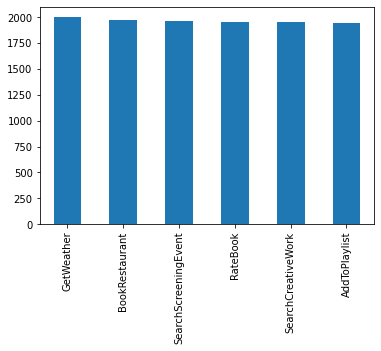

In [12]:
train_data['label'].value_counts().plot(kind='bar')

In [13]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(label_train)

label_train = idx_encode.transform(label_train)
label_test = idx_encode.transform(label_test)

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print('레이블과 정수의 맵핑 관계 :', label_idx)

레이블과 정수의 맵핑 관계 : {'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


In [14]:
print(intent_train[:5])
print(label_train[:5])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams', 'add live from aragon ballroom to trapeo', 'add unite and win to my night out', 'add track to my digster future hits']
[0 0 0 0 0]


In [15]:
print(intent_test[:5])
print(label_test[:5])

["i 'd like to have this track onto my classical relaxations playlist", 'add the album to my flow espa ol playlist', 'add digging now to my young at heart playlist', 'add this song by too poetic to my piano ballads playlist', 'add this album to old school death metal']
[0 0 0 0 0]


In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5] # 상위 5개 샘플 출력

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

In [17]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 9870


문장의 최대 길이 : 35
문장의 평균 길이 : 9.364392396469789


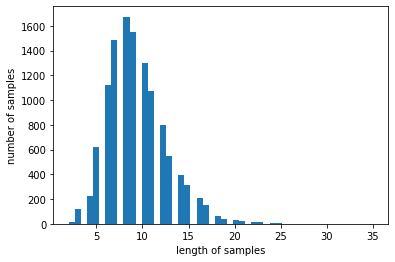

In [18]:
print('문장의 최대 길이 :',max(len(l) for l in sequences))
print('문장의 평균 길이 :',sum(map(len, sequences))/len(sequences))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
max_len = 35

intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))
print('훈련 데이터의 크기(shape):', intent_train.shape)
print('훈련 데이터 레이블의 크기(shape):', label_train.shape)

훈련 데이터의 크기(shape): (11784, 35)
훈련 데이터 레이블의 크기(shape): (11784, 6)


In [20]:
print('훈련 데이터의 첫번째 샘플 :',intent_train[0])
print('훈련 데이터의 첫번째 샘플의 레이블 :',label_train[0])

훈련 데이터의 첫번째 샘플 : [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   11  191
   61    4    1 4013 1141 1572   15]
훈련 데이터의 첫번째 샘플의 레이블 : [1. 0. 0. 0. 0. 0.]


In [21]:
indices = np.arange(intent_train.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [ 8199  6120  4095 ...  4472 10135  7557]


In [22]:
n_of_val = int(0.1 * intent_train.shape[0])
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 1178


In [23]:
X_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]
X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]
X_test = intent_test
y_test = label_test

In [24]:
print('훈련 데이터의 크기(shape):', X_train.shape)
print('검증 데이터의 크기(shape):', X_val.shape)
print('훈련 데이터 레이블의 크기(shape):', y_train.shape)
print('검증 데이터 레이블의 크기(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 크기(shape): (10606, 6)
검증 데이터 레이블의 크기(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


## 사전 훈련된 워드 임베딩 사용하기

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-02-27 23:36:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-27 23:36:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-27 23:36:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [26]:
embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [27]:
print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

In [28]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))

임베딩 테이블의 크기(shape) : (9870, 100)


In [29]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## 1D CNN을 이용한 의도 분류

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPool1D, Dense, Input, Flatten, Concatenate

kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
  conv = Conv1D(filters = num_filters,
                kernel_size=size,
                padding='valid',
                activation='relu',
                strides=1)(output)
  conv = GlobalMaxPool1D()(conv)
  conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)
model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 100)      987000      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 34, 512)      102912      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 33, 512)      154112      ['embedding[0][0]']              
                                                                                              

In [31]:
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data=(X_val, y_val))

Epoch 1/10
166/166 [==============================] - 19s 104ms/step - loss: 0.1771 - acc: 0.9490 - val_loss: 0.2813 - val_acc: 0.9049
Epoch 2/10
166/166 [==============================] - 26s 160ms/step - loss: 0.0403 - acc: 0.9893 - val_loss: 0.1611 - val_acc: 0.9457
Epoch 3/10
166/166 [==============================] - 16s 98ms/step - loss: 0.0250 - acc: 0.9931 - val_loss: 0.3112 - val_acc: 0.8939
Epoch 4/10
166/166 [==============================] - 16s 98ms/step - loss: 0.0139 - acc: 0.9962 - val_loss: 0.1483 - val_acc: 0.9576
Epoch 5/10
166/166 [==============================] - 16s 99ms/step - loss: 0.0118 - acc: 0.9974 - val_loss: 0.1563 - val_acc: 0.9533
Epoch 6/10
166/166 [==============================] - 17s 102ms/step - loss: 0.0076 - acc: 0.9980 - val_loss: 0.2571 - val_acc: 0.9270
Epoch 7/10
166/166 [==============================] - 16s 99ms/step - loss: 0.0080 - acc: 0.9973 - val_loss: 0.1652 - val_acc: 0.9550
Epoch 8/10
166/166 [==============================] - 17s 1

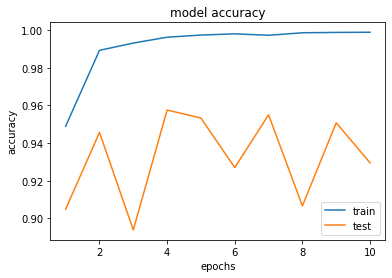

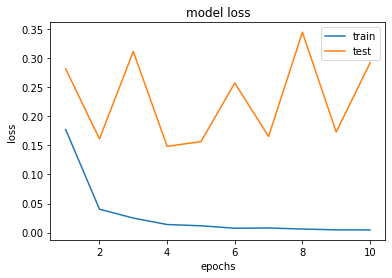

In [32]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [33]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

In [34]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측을 정수 시퀀스로 변환

In [35]:
print('정확도(Accuracy) : ', sum(y_predicted == y_test) / len(y_test))

정확도(Accuracy) :  0.9833333333333333
